# Neurons with consistent firing, but not predicted by movement - Supplementary Figure 1
This notebook contains mostly plotting of neurons that are consistent in firing, but not predicted by movement. These are later shown in Supplementary Figure 1, and their proportion per area is used in a reviewer response figure.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import pickle

import local_env
import VideoAnalysisUtils.functions as func

In [2]:
figfolder = '../figs/supplementary_figs/'
datafolder = '../data/'

os.makedirs(os.path.abspath(figfolder), exist_ok=True)

## Load data and some simple plots

In [3]:
r2_new = pickle.load(open('../data/final/r2_embed_cv_timeshift.pkl', 'rb'))
timeshifts = np.arange(-30,32,2, dtype = int)
method_to_string = {'old': '_old', 'old_clipped': '_old', 'new': ''}

epoch = 'response'
r2_method = 'new'

r2 = []
fr = r2_new['5_0']['%s_fr'%epoch].copy()
ccf_coords = r2_new['5_0']['ccf_coords'].copy()

for timesh in timeshifts:
    r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%(epoch,method_to_string[r2_method])].copy())

r2 = np.array(r2)
best_times = 3.4 * timeshifts[r2.argmax(axis = 0)]

delta_r2 = 1.20
fr_threshold = 2.
r2_threshold = 0.01

voxel_size = 300



delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
fr_inds = np.where(fr > fr_threshold)[0]
threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0],:] > r2_threshold)[0]
threshold_inds = np.intersect1d(threshold_inds, fr_inds)
restriction_inds = np.intersect1d(threshold_inds, delta_inds)

In [4]:
r2_noshift = r2_new['5_0']['%s_r2%s'%(epoch,method_to_string[r2_method])].copy()
is_alm = r2_new['5_0']['is_alm'].copy()
alm_inds = np.where(is_alm)[0]
ccf_labels = r2_new['5_0']['ccf_labels'].copy()
file_name = 'r2_data_dict_expanded_smallwindow_subtract_pertimeavg.pkl'
allen_hierarchy_file_name = 'mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx'
areas = ['Medulla','Midbrain', 'ALM', 'Striatum', 'Thalamus']
df = pd.read_excel(datafolder + allen_hierarchy_file_name, engine='openpyxl', header = None, names = ['id','region','tree'])
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)

In [5]:
trial_by_trial_var = r2_new['5_0']['trial_to_trial_var'].copy()
mean_corr_fr = r2_new['5_0']['mean_corr_fr'].copy()
noshift_r2 = r2_new['5_0']['response_r2%s'%method_to_string[r2_method]].copy()
noshift_r2[noshift_r2<0] = 0

In [20]:
data = [trial_by_trial_var, np.nan_to_num(mean_corr_fr), best_times, noshift_r2]
data_names = ['trial_by_trial_var', 'mean_corr_fr', 'best_timeshifts', 'noshift_r2']

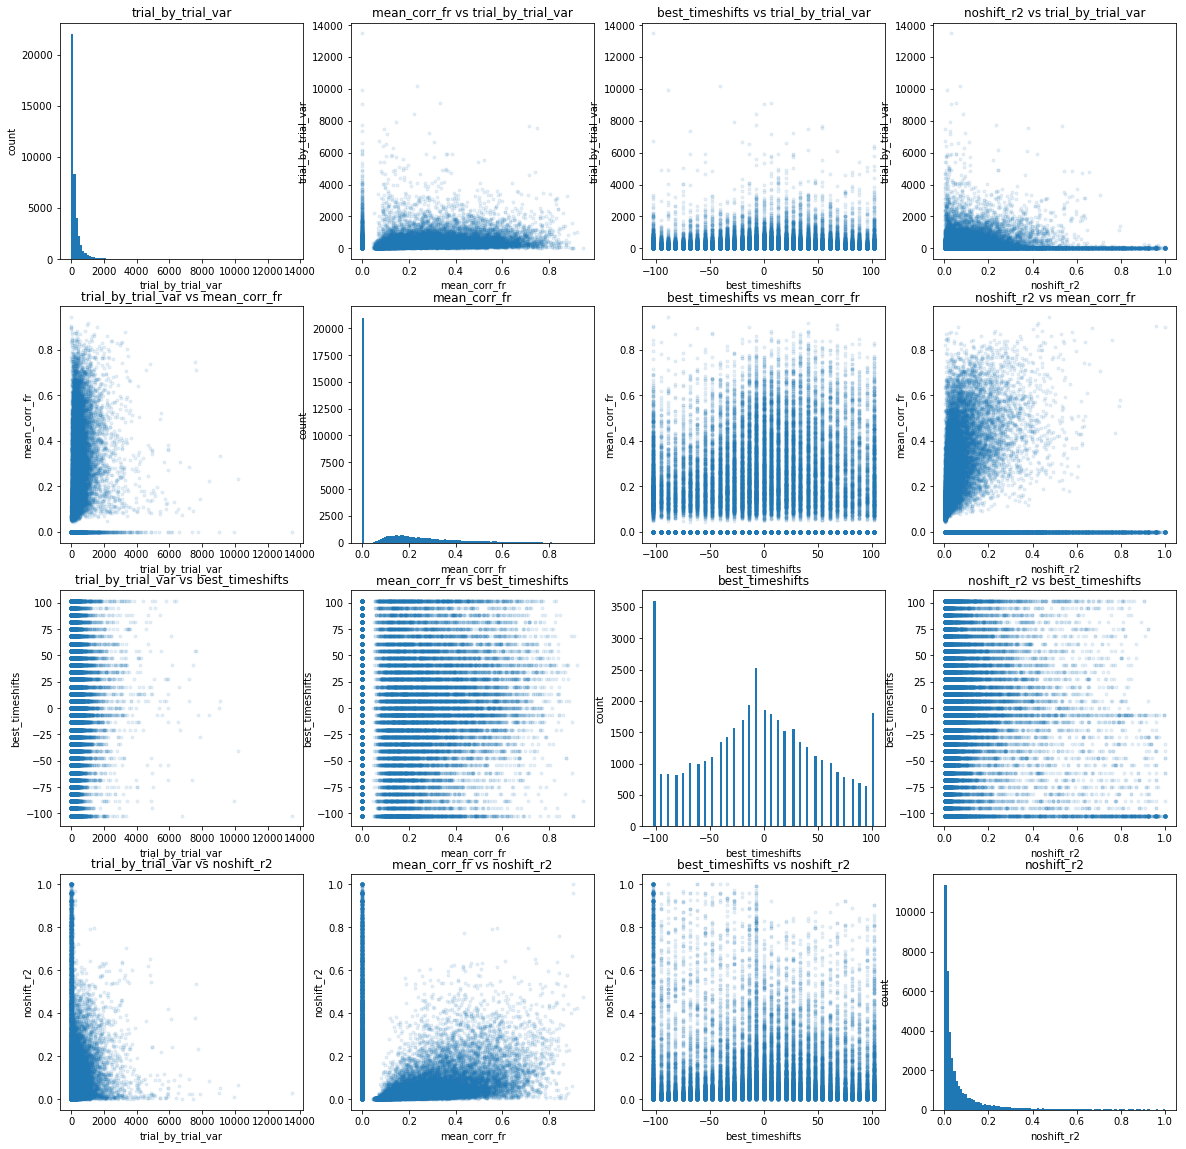

In [21]:
plt.subplots(4,4, figsize = (20,20))

for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*j+i+1)
        if i == j:
            plt.hist(data[i], bins = 100)
            plt.title(data_names[i])
            plt.xlabel(data_names[i])
            plt.ylabel('count')
        else:
            plt.plot(data[i], data[j], '.', alpha = 0.1)
            plt.title(data_names[i] + ' vs ' + data_names[j])
            plt.xlabel(data_names[i])
            plt.ylabel(data_names[j])



## Find neurons of interest

In [22]:
mean_no_nan = np.nan_to_num(mean_corr_fr)

In [23]:
extreme_mask = np.union1d(np.where(mean_no_nan == 0)[0], np.where(np.abs(best_times) > 110)[0])

s1_like_mask = np.where(mean_no_nan > 0.4)[0]
print(s1_like_mask.shape)
s1_like_mask = np.intersect1d(s1_like_mask, np.where(trial_by_trial_var < 100)[0])
print(s1_like_mask.shape)
s1_like_mask = np.intersect1d(s1_like_mask, np.where(noshift_r2 < 0.1)[0])
print(s1_like_mask.shape)

s1_like_inds = np.setdiff1d(s1_like_mask, extreme_mask)

(4082,)
(250,)
(196,)


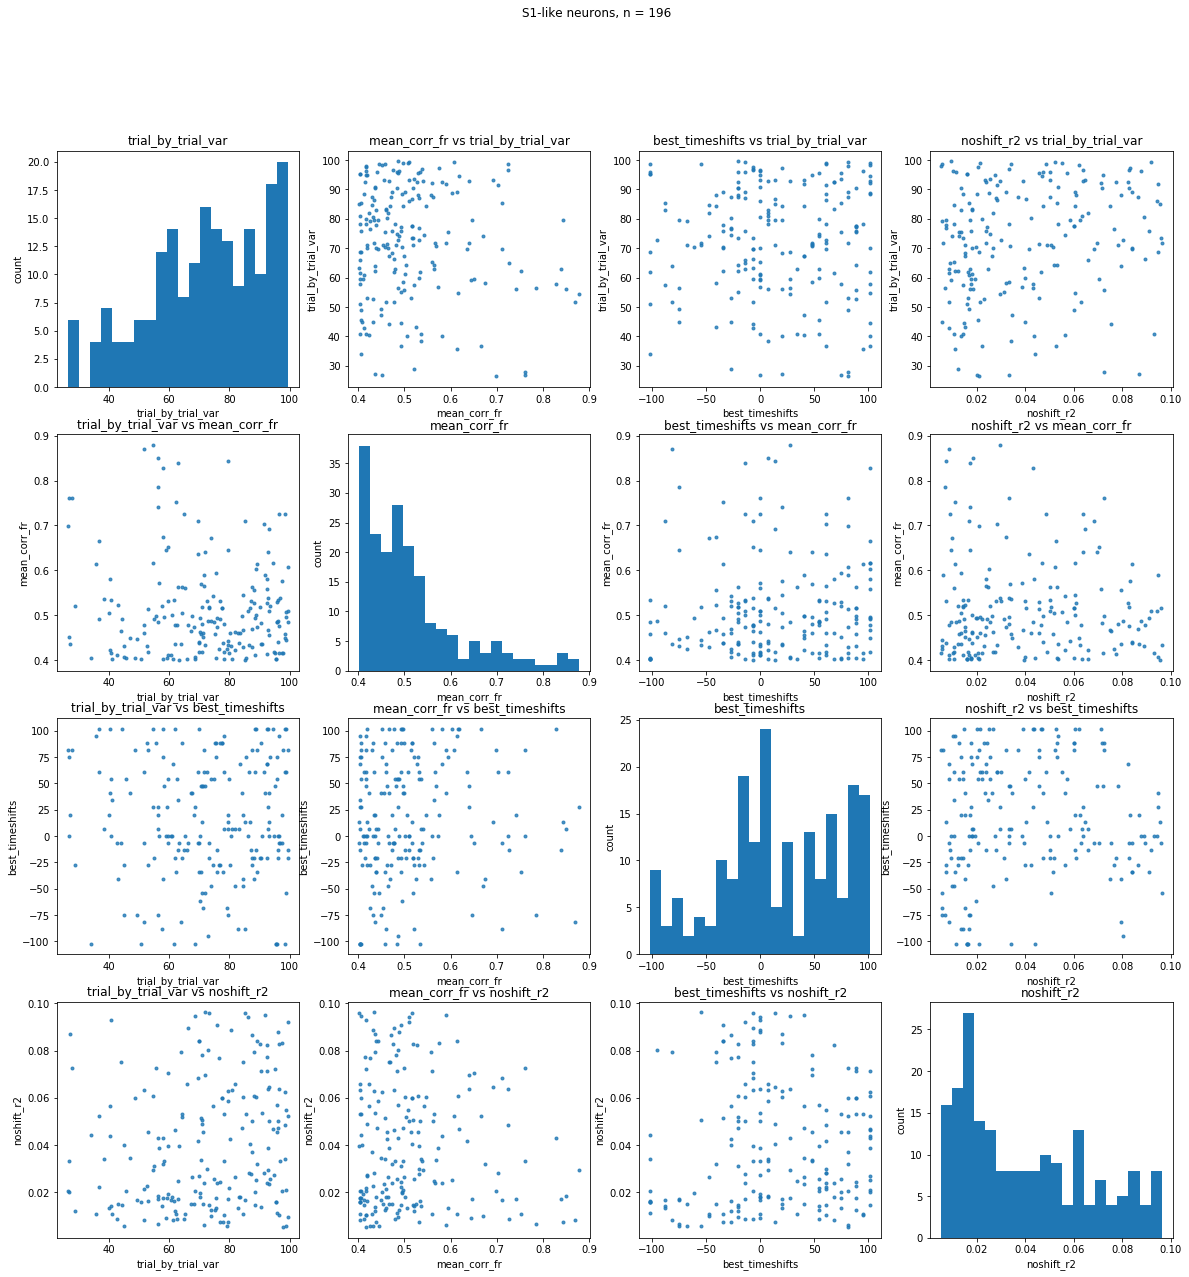

In [24]:
f, _ = plt.subplots(4,4, figsize = (20,20))
f.suptitle('S1-like neurons, n = %d'%s1_like_inds.shape[0])
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*j+i+1)
        if i == j:
            plt.hist(data[i][s1_like_inds], bins = 20)
            plt.title(data_names[i])
            plt.xlabel(data_names[i])
            plt.ylabel('count')
        else:
            plt.plot(data[i][s1_like_inds], data[j][s1_like_inds], '.', alpha = 0.8)
            plt.title(data_names[i] + ' vs ' + data_names[j])
            plt.xlabel(data_names[i])
            plt.ylabel(data_names[j])

#plt.savefig(figfolder + 's1_like_neurons_draftsman.png')

In [11]:
s1_like_neurons = {}

for i in s1_like_inds:
    s1_like_neurons[i] = {
        'session': r2_new['5_0']['session_name'][i], 
        'ccf_label': r2_new['5_0']['ccf_labels'][i], 
        'ccf_coords': r2_new['5_0']['ccf_coords'][i],
        'within_session_ind': i - np.min(np.where(r2_new['5_0']['session_name'] == r2_new['5_0']['session_name'][i])[0])}

#pickle.dump(s1_like_neurons, open(datafolder + 's1_like_neuron_inds.pkl', 'wb'))

## Visualize the neurons we found

In [8]:
s1_like_neuron_data = pickle.load(open(datafolder + 's1_like_neuron_fr.pkl', 'rb'))

In [9]:
tt = s1_like_neuron_data[406]['tt']

fr_list = []
r2_list = []
session_list = []

for ind, data in s1_like_neuron_data.items():
    fr_list.append(data['fr'])
    r2_list.append(data['r2'])
    session_list.append(data['session'])


len(fr_list)

196

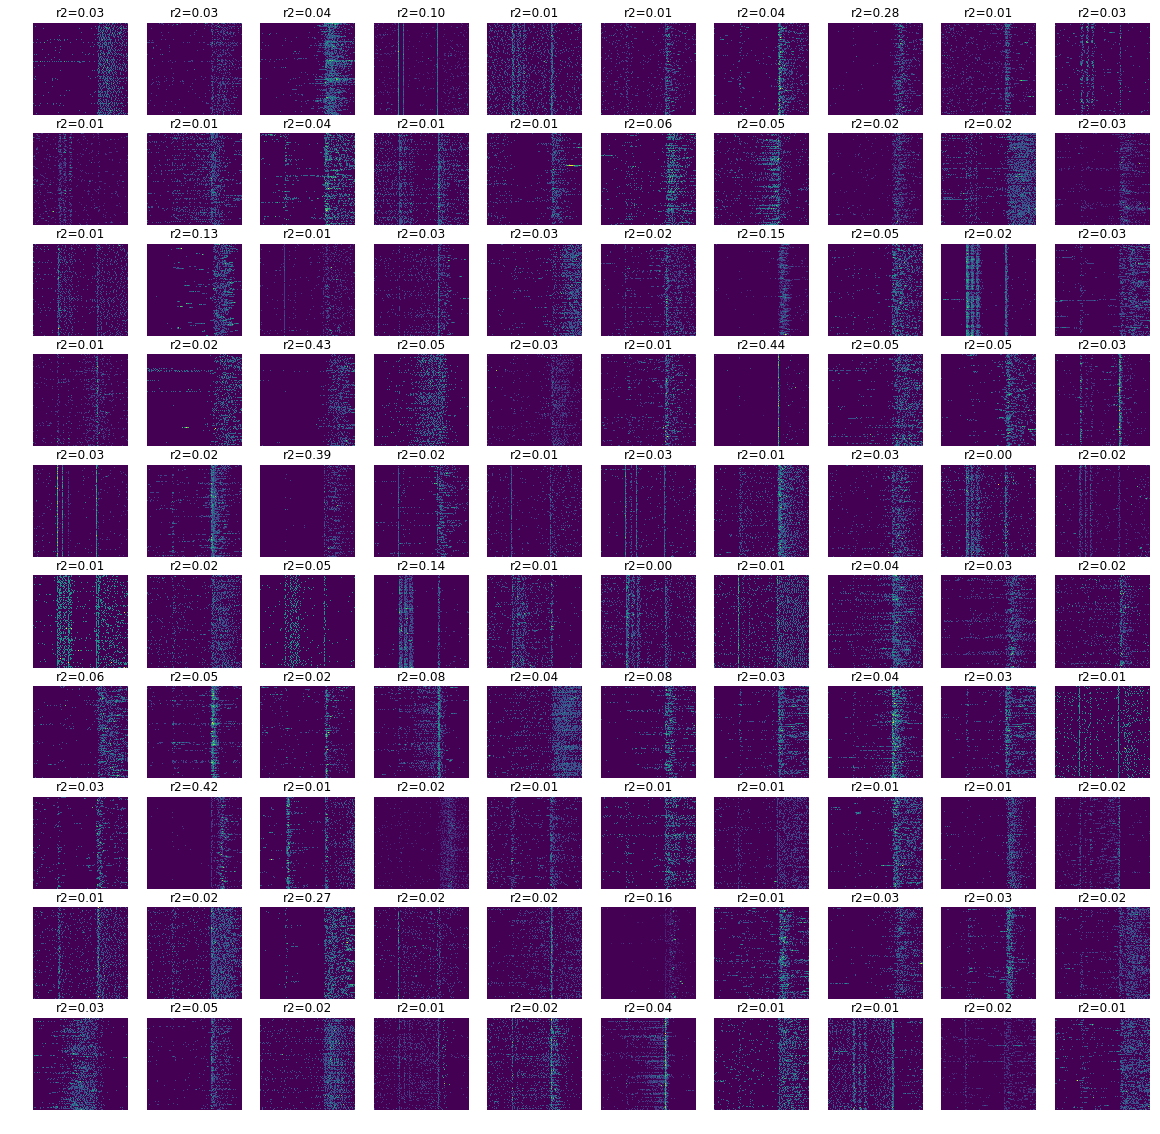

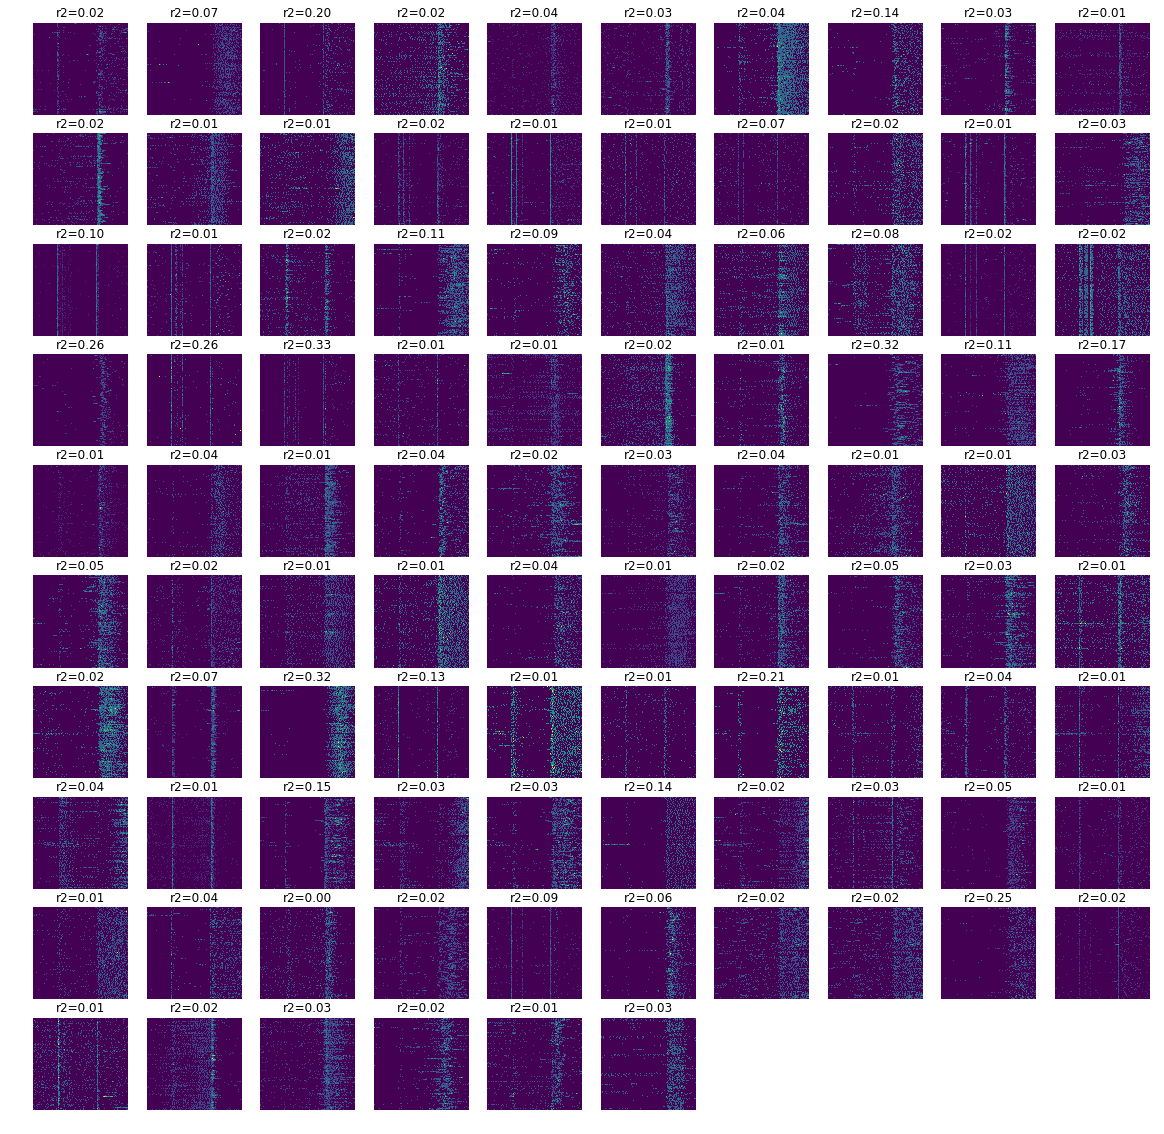

In [10]:
relu = lambda x: np.maximum(0, x)

for i in range(2):
    plt.subplots(10,10, figsize = (20,20))

    for j in range(100):
        plt.subplot(10,10,j+1)
        if j + i*100 >= len(fr_list):
            plt.axis('off')
        else:
            plt.imshow(fr_list[i*100+j].T, cmap = 'viridis', aspect = 'auto', extent = [tt[0], tt[-1], 0, fr_list[i*100+j].shape[0]])
            plt.title('r2=%.2f'%relu(r2_list[i*100 + j]).mean(),)
            plt.axis('off')

    plt.show()
    plt.close()
        

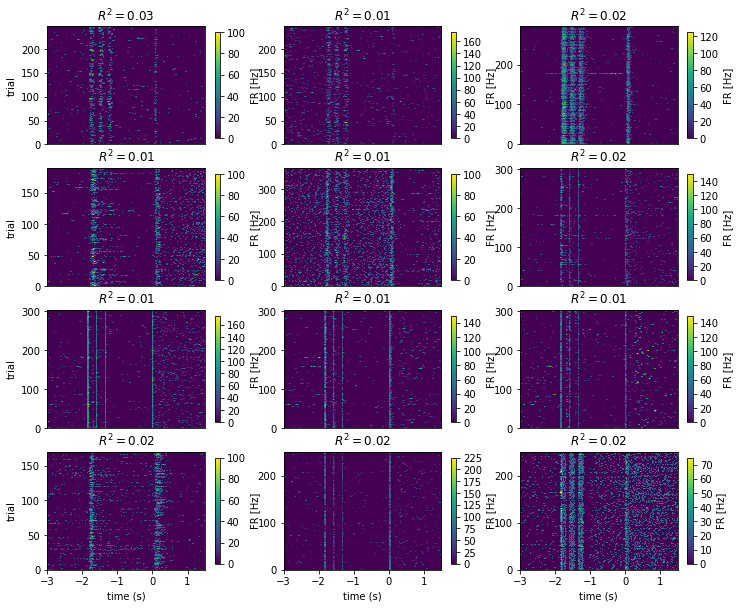

In [12]:
interesting_inds = [9, 10, 28, 72, 97, 113,114,118,121,122, 128, 129]

plt.subplots(4,3, figsize = (12,10))

for i in range(12):
    plt.subplot(4,3,i+1)
    plt.imshow(fr_list[interesting_inds[i]].T, cmap = 'viridis', aspect = 'auto', extent = [tt[0], tt[-1], 0, fr_list[interesting_inds[i]].shape[1]])
    plt.colorbar(shrink = 0.9, label = 'FR [Hz]')
    plt.title(r'$R^2 = $%.2f'%relu(r2_list[interesting_inds[i]]).mean())

    if i // 3 == 3:
        plt.xlabel('time (s)')
    else:
        plt.xticks([])
    if i % 3 == 0:
        plt.ylabel('trial')

#plt.savefig(figfolder + 'S1_multiple_neurons.png', dpi = 300)

## Create S1 figure

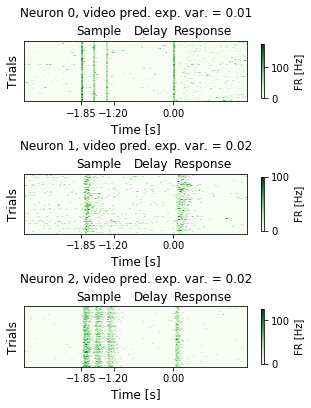

In [13]:
final_inds = [114, 122, 28]

plt.subplots(3,1, figsize = (5,6))
plt.subplots_adjust(hspace = 1.2)

epoch_labels = ['Sample', 'Delay', 'Response']

for i in range(3):
    plt.subplot(3,1,i+1)
    plt.imshow(fr_list[final_inds[i]].T, cmap = 'Greens', aspect = 'auto', extent = [tt[0], tt[-1], 0, fr_list[final_inds[i]].shape[1]])
    plt.colorbar(shrink = 0.9, label = 'FR [Hz]', ticks = [0, 100])
    plt.title('Neuron %d, video pred. exp. var. = %.2f'%(i,relu(r2_list[final_inds[i]]).mean()), pad = 24, fontsize = 12)
    plt.xlabel('Time [s]', fontsize = 12)
    plt.ylabel('Trials', fontsize = 12)
    plt.yticks([])
    for j in range(3):
        plt.text(-1.5 + 1.05*j, fr_list[final_inds[i]].shape[1]*1.05, epoch_labels[j], fontsize = 12, va = 'bottom', ha = 'center')
    plt.xticks([-1.85, -1.2, 0], fontsize = 10)

#plt.savefig(figfolder + 'S1.pdf', dpi = 300)

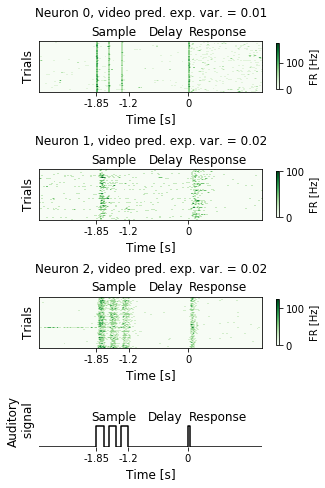

In [14]:
final_inds = [114, 122, 28]
epoch_labels = ['Sample', 'Delay', 'Response']

# Create a figure with a 4x1 grid layout
fig = plt.figure(figsize=(5, 8))
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 1])
plt.subplots_adjust(hspace=1.5)

# Loop through the first 3 subplots and add colorbars
for i in range(3):
    ax = plt.subplot(gs[i])
    im = ax.imshow(fr_list[final_inds[i]].T, cmap='Greens', aspect='auto',
                   extent=[tt[0], tt[-1], 0, fr_list[final_inds[i]].shape[1]])
    
    # Add colorbar and position it beside the plot
    cbar = plt.colorbar(im, ax=ax, shrink=0.9, label='FR [Hz]', ticks=[0, 100])
    
    # Set plot title, labels, and other plot elements
    ax.set_title(f'Neuron {i}, video pred. exp. var. = {relu(r2_list[final_inds[i]]).mean():.2f}', 
                 pad=24, fontsize=12)
    ax.set_xlabel('Time [s]', fontsize=12)
    ax.set_ylabel('Trials', fontsize=12)
    ax.set_yticks([])

    # Add custom epoch labels
    for j in range(3):
        ax.text(-1.5 + 1.05 * j, fr_list[final_inds[i]].shape[1] * 1.05, epoch_labels[j], 
                fontsize=12, va='bottom', ha='center')
    ax.set_xticks([-1.85, -1.2, 0])
    ax.set_xticklabels([-1.85, -1.2, 0], fontsize=10)

# Fourth subplot without colorbar but adjusting width manually
ax4 = plt.subplot(gs[3])
ax4.set_position([ax4.get_position().x0,  # Move left
                ax4.get_position().y0 + 0.05,  # Move down
                ax.get_position().width, 
                ax.get_position().height])

ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['bottom'].set_visible(False)

# Add the task plot in the 4th panel
x_task = [-3] + [-1.85, -1.85, -1.7, -1.7, -1.6, -1.6, -1.45, -1.45, -1.35, -1.35, -1.2, -1.2] + [0, 0, 0.05, 0.05, 1.5]
y_task = [0] + [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0] + [0, 1, 1, 0, 0]

ax4.plot(x_task, y_task, 'k')
ax4.set_xlim(-3, 1.5)
ax4.set_ylim(0, 2.5)
ax4.set_xlabel('Time [s]', fontsize=12)
ax4.set_ylabel('Auditory\n signal', fontsize=12)
ax4.set_xticks([-1.85, -1.2, 0])
ax4.set_xticklabels([-1.85, -1.2, 0], fontsize=10)
ax4.set_yticks([])

# Add epoch labels for the 4th panel
for j in range(3):
    ax4.text(-1.5 + 1.05 * j, 1 * 1.15, epoch_labels[j], fontsize=12, va='bottom', ha='center')

# Save the figure
#plt.savefig(figfolder + 'S1_v2.pdf', dpi=300)
plt.show()


## Area breakdown as asked by reviewer

In [25]:
areas = ['Medulla','Midbrain', 'ALM', 'Striatum', 'Thalamus']
area_inds = {}
area_inds_no_restriction = {}
for area in areas:
    inds = func.get_single_area_inds(area, df, ccf_labels, alm_inds)
    area_inds_no_restriction[area] = inds
    area_inds[area] = np.intersect1d(inds, restriction_inds)

In [26]:
N_no_restriction = np.array([len(area_inds_no_restriction[area]) for area in areas])
N_restriction = np.array([len(area_inds[area]) for area in areas])
N_s1_like = np.array([len(np.intersect1d(area_inds[area], s1_like_inds)) for area in areas])
N_s1_like_no_restriction = np.array([len(np.intersect1d(area_inds_no_restriction[area], s1_like_inds)) for area in areas])
N_negative_timeshift = np.array([len(np.where(best_times[area_inds[area]] < 0)[0]) for area in areas])
N_negative_timeshift_no_restriction = np.array([len(np.where(best_times[area_inds_no_restriction[area]] < 0)[0]) for area in areas])


([<matplotlib.axis.XTick at 0x7f9ad2593d30>,
 <a list of 5 Text xticklabel objects>)

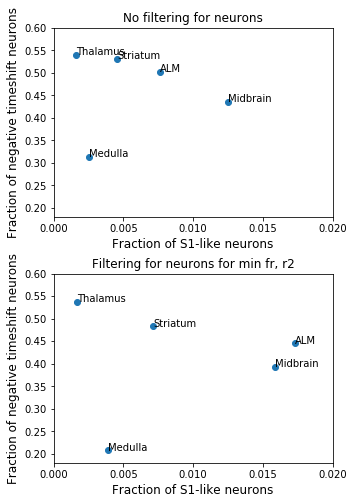

In [27]:
plt.subplots(2,1, figsize = (5,8))
plt.subplots_adjust(hspace = 0.3)

plt.subplot(2,1,1)
plt.title('No filtering for neurons', fontsize = 12)
plt.plot(N_s1_like_no_restriction / N_no_restriction,N_negative_timeshift_no_restriction / N_no_restriction, 'o')
for i in range(5):
    plt.text(N_s1_like_no_restriction[i] / N_no_restriction[i], N_negative_timeshift_no_restriction[i] / N_no_restriction[i], areas[i], fontsize = 10)
plt.xlabel('Fraction of S1-like neurons', fontsize = 12)
plt.ylabel('Fraction of negative timeshift neurons', fontsize = 12)
plt.xlim(0,0.02)
plt.ylim(0.18,0.6)
plt.xticks(np.arange(0,0.021,0.005))

plt.subplot(2,1,2)
plt.title('Filtering for neurons for min fr, r2', fontsize = 12)
plt.plot(N_s1_like / N_restriction,N_negative_timeshift / N_restriction, 'o')
for i in range(5):
    plt.text(np.array(N_s1_like / N_restriction)[i], np.array(N_negative_timeshift / N_restriction)[i], areas[i], fontsize = 10)
plt.xlabel('Fraction of S1-like neurons', fontsize = 12)
plt.ylabel('Fraction of negative timeshift neurons', fontsize = 12)
plt.xlim(0,0.02)
plt.ylim(0.18,0.6)
plt.xticks(np.arange(0,0.021,0.005))

#plt.savefig(figfolder + 'S1_like_neurons_fraction.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
import VideoAnalysisUtils.plot_style as style

([<matplotlib.axis.XTick at 0x7f9ad226f8e0>,
 <a list of 5 Text xticklabel objects>)

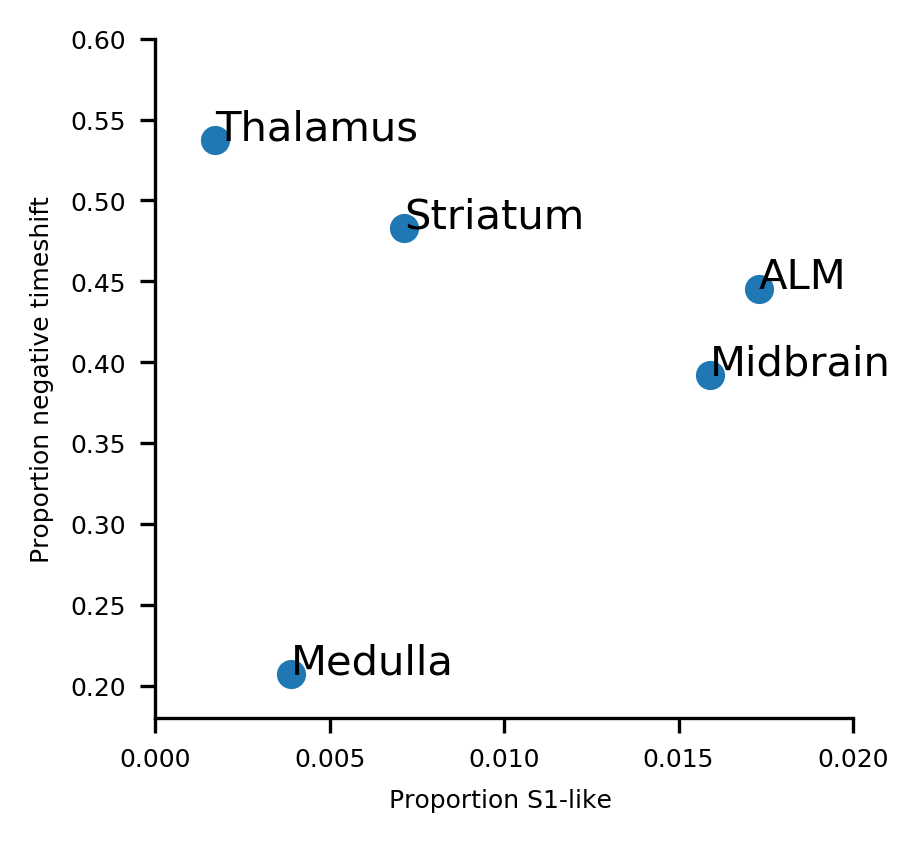

In [29]:
plt.figure(figsize = (3,3))
plt.plot(N_s1_like / N_restriction,N_negative_timeshift / N_restriction, 'o')
for i in range(5):
    plt.text(np.array(N_s1_like / N_restriction)[i], np.array(N_negative_timeshift / N_restriction)[i], areas[i], fontsize = 10)
plt.xlabel('Proportion S1-like ',)
plt.ylabel('Proportion negative timeshift', )
plt.xlim(0,0.02)
plt.ylim(0.18,0.6)
plt.xticks(np.arange(0,0.021,0.005))

#plt.savefig('../figs/reviewer_figures/s1_like_neurons_fraction.png', dpi = 300, bbox_inches = 'tight')